# Sexism Classification with BLSTM and Transformer
In this notebook, we have implemented two BLSTM models and imported RoBERTa transoformer. Then we used these to study a classification problem. The problem is defined as whether a given tweeet is sexism.



## Outlines
1. [Packages](#packages)
2. [Corpus](#corpus)
3. [Corpus Settings](#corpus-settings)
4. [Data Cleaning](#data-cleaning)
5. [Bidirectional LSTM Model](#bidirectional-LSTM-model)
    1. [Step 1 - Tokenization](#tokenization)
        1. [Download and Import GloVe](#glvoe)
        2. [Build Vocabulary - Word Tokenization](#word-tokenization)
        3. [Build Vocabulary - BPE](#bpe)
    2. [Step 2 - Embeddings](#embeddings)
        1. [Words' ID and Tweets' Sequence IDs](#word-ID)
        2. [Checking OOV](#word-OOV)
        3. [Embedding Matrix](#embedding-matrix)
    3. [Step 3 - Paddings](#padding)
    4. [Step 4 - Model Definition](#blstm-model-definition)
    5. [Step 5 - Training](#blstm-training)
    6. [Step 6 - Test Evaluation](#blstm-test-evaluation)
6. [Transformer Model](#transformer-model)
    1. [Importing Transformer and Preprocessing](#transformer-preprocessing)
    2. [Defining the model and Metrics](#transformer-modeling)
    3. [Training](#transformer-training)
    4. [Test Evaluation](#transformer-test-evaluation)
7. [Results Analysis](#result-analysis)
    1. [BLSTM Curve Analysis](#curve-analysis)
    2. [Vocabulary and Tokenization Analysis](#tokenization-analysis)
    3. [Confusion Matrix Analysis](#confusion-matrix-analysis)
    4. [Other Notes](#other-analysis)


<a name='packages'></a>
# Packages
This sections will import and install all the necessary libraries for this project.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Uncomment this cell if you don't have access locally, ow. change the paths to your local
# Download GloVe embeddings
# GloVe Embeddings are a type of word embedding that encode the co-occurrence
# probability ratio between two words as vector differences.
# Ref: https://paperswithcode.com/method/glove
# Following Glove Link is from its official Github account
# You can download them to your workspace by uncommenting the following lines or,
# if you already have it, later in the notebook, you can change the path to yours

# Uncomment next two for the 840B tokens with 300D version of Glove
# !wget -p "/content/drive/MyDrive/Colab Notebooks/Sexism Detection/embeddings" https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip
# !unzip "/content/drive/MyDrive/Colab Notebooks/Sexism Detection/embeddings/glove.840B.300d.zip"

# Uncomment next two for the 6B tokens with 50D, 100D, 200D, 300D version of Glove
# !wget -p "/content/drive/MyDrive/Colab Notebooks/Sexism Detection/embeddings" https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
# !unzip "/content/drive/MyDrive/Colab Notebooks/Sexism Detection/embeddings/glove.6B.zip"

In [ ]:
%%capture
!pip install transformers datasets evaluate

In [ ]:
# Packages
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Activation
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import DataCollatorWithPadding
from tensorflow.keras.models import Sequential
from transformers import set_seed

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import re

from torch.utils.data import Dataset
from datasets import Dataset as DS
import evaluate
import torch

from nltk.stem import WordNetLemmatizer
import nltk

from collections import Counter
from pathlib import Path
import numpy as np
import warnings
import random
import os

warnings.filterwarnings("ignore", category=FutureWarning)

<a name='corpus'></a>
# Corpus
In this section we have downloaded the data from the [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data) and add it to our directory.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class. In the following cells, I will discusss how I handled the balance and unbalance dataset.


In [ ]:
# Updated the following paths base on your own environment
path_to_trai_json = '/content/drive/MyDrive/Colab Notebooks/Sexism Detection/data/training.json'
path_to_val_json = '/content/drive/MyDrive/Colab Notebooks/Sexism Detection/data/validation.json'
path_to_test_json = '/content/drive/MyDrive/Colab Notebooks/Sexism Detection/data/test.json'

def load_json_to_df(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return pd.DataFrame.from_dict(data, orient='index')

# Load the JSON files into pandas DataFrames
train_df = load_json_to_df(path_to_trai_json)
val_df = load_json_to_df(path_to_val_json)
test_df = load_json_to_df(path_to_test_json)

print("Train df shape:", train_df.shape)
print("Validation df shape:", val_df.shape)
print("Test df shape:", test_df.shape)

train_df.head(3)

Train df shape: (6920, 11)
Validation df shape: (726, 11)
Test df shape: (312, 11)


,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES


<a name='corpus-settings'></a>
# Corpus Settings
In this step, we will modify the dataset with defined rules settings.

In [ ]:
def majority_voting(labels):
    count = Counter(labels)
    if count['YES'] > count['NO']:
        return 'YES'
    elif count['NO'] > count['YES']:
        return 'NO'
    else:
        return None

def initial_process(df):
    # Generate hard labels using majority voting
    df['hard_label_task1'] = df['labels_task1'].apply(majority_voting)

    # Remove rows without a clear majority
    df = df.dropna(subset=['hard_label_task1'])

    # Filter for English tweets
    df = df[df['lang'] == 'en']

    # Keep only relevant columns
    df = df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]

    # Encode the hard labels
    df['hard_label_task1'] = df['hard_label_task1'].map({'YES': 1, 'NO': 0})

    # Display the resulting DataFrame
    return df

train_df = initial_process(train_df)
val_df = initial_process(val_df)
test_df = initial_process(test_df)

print("Train df shape:", train_df.shape)
print("Validation df shape:", val_df.shape)
print("Test df shape:", test_df.shape)
print("\n=== Number of datapoints per dataset&class ===")
print("Training Set:")
print(train_df['hard_label_task1'].value_counts())
print("\nValidation Set:")
print(val_df['hard_label_task1'].value_counts())
print("\nTest Set:")
print(test_df['hard_label_task1'].value_counts())

Train df shape: (2870, 4)
Validation df shape: (158, 4)
Test df shape: (286, 4)

=== Number of datapoints per dataset&class ===
Training Set:
hard_label_task1
0    1733
1    1137
Name: count, dtype: int64

Validation Set:
hard_label_task1
0    90
1    68
Name: count, dtype: int64

Test Set:
hard_label_task1
0    160
1    126
Name: count, dtype: int64


Results above shows the the number of datapoints that we have for the `none sexist` class, class 0, is slightly more than the other one.

We didn't get rid of this unbalanced dataset in this project. In fact, using this unbalance dataset, we have created another training dataset in which the class with higher frequency is downsampled to the other class and we have a balance number of both. Hence, from now on we have two datsets:
- `train_df`: The main dataset with its unbalancy.
- `train_df_balanced`: The new dataset in which we have a same amount of classes.

In this project we will use both of these datasets to train the defined models and we will discuss and analyse them together.

Next cell, creates this second balanced dataset with downsampling. Moreover, the number of data is few, and downsampling narrows it even more. Hence, a better approach would be to upsample the data of the class with fewer frequency, which can be done in future experiments.

In [ ]:
# Separate majority and minority classes
df_majority = train_df[train_df['hard_label_task1'] == 0]
df_minority = train_df[train_df['hard_label_task1'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
train_df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print("=== Number of datapoints per dataset&class after downsampling ===")
print(train_df_balanced['hard_label_task1'].value_counts())
train_df_balanced.info()

=== Number of datapoints per dataset&class after downsampling ===
hard_label_task1
0    1137
1    1137
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 2274 entries, 200685 to 203260
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_EXIST          2274 non-null   object
 1   lang              2274 non-null   object
 2   tweet             2274 non-null   object
 3   hard_label_task1  2274 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 88.8+ KB


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2870 entries, 200002 to 203260
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_EXIST          2870 non-null   object
 1   lang              2870 non-null   object
 2   tweet             2870 non-null   object
 3   hard_label_task1  2870 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 176.6+ KB


<a name='data-cleaning'></a>
# Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis. Although these may be important in other tasks, here we will drop them from the data.

We will do a small data cleaning to omit the parts of the tweet that does not contain any information. This is done by the following `clean tweet` function which takes a tweet in and returns it cleaner than ever ;).

> Writing regex patterns is important, complex and may some time need a little bit experience. Here, I have used Gemini to get the initial patterns. However, as LLMs make mistakes (quite a lot) I have also used the online tool [Regex 101](https://regex101.com/) to check the soundness of patterns. Following cell is a small colaboration with Gemini.

In [ ]:
def clean_tweet(tweet):
    # Remove(substitute with "") emojis and non Ascii
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)

    # Remove hashtags or complex usage of hashtags
    tweet = re.sub(r'#+\w+|#+', '', tweet)

    # Remove mentions or more complex uses of @
    tweet = re.sub(r'@+\w+|@+', '', tweet)

    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # Remove special characters; Look for something, remove something else
    tweet = re.sub(r'[^\w\s]', '', tweet)

    # Remove specific quote characters; less probable to occur
    tweet = re.sub(r'[\u2018\u2019\u201C\u201D]', '', tweet)

    return tweet

# Apply the cleaning function to the 'tweet' column
train_df['cleaned_tweet'] = train_df['tweet'].apply(clean_tweet)
train_df_balanced['cleaned_tweet'] = train_df_balanced['tweet'].apply(clean_tweet)
val_df['cleaned_tweet'] = val_df['tweet'].apply(clean_tweet)
test_df['cleaned_tweet'] = test_df['tweet'].apply(clean_tweet)

In the next cell, we have used the `nltk` tool to lemmatize the input text to their base form. This process, as well as the cleanning process we saw in the previous cell, is being applied to the both of the training sets along with validation and test sets.

In [ ]:
#Lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    '''
    inputes:
        - text: the input tweet
    outputs:
        - lemmatized_words: the lemmatized tweet
    '''
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized_words)

# Apply the cleaning function to the 'tweet' column
train_df['lemmatized_tweet'] = train_df['cleaned_tweet'].apply(lemmatize_text)
train_df_balanced['lemmatized_tweet'] = train_df_balanced['cleaned_tweet'].apply(lemmatize_text)
val_df['lemmatized_tweet'] = val_df['cleaned_tweet'].apply(lemmatize_text)
test_df['lemmatized_tweet'] = test_df['cleaned_tweet'].apply(lemmatize_text)
train_df.shape, train_df_balanced.shape

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


((2870, 6), (2274, 6))

<a name='bidirectional-LSTM-model'></a>
# Bidirectional LSTM Model
In this section we will go through step to step preparation of our architecure and we will implements necessary parts that have to be done before doing training.

<a name='tokenization'></a>
## Step 1 - Tokenization
We have preprocessed the entire data we had. Now it's time tokenize the data and create our vocabulary. We can do this part with two approach here:
- One approach is to just simply consider all the word type (words that are unique) and are processed and lemmatized as a token and add them to vocabulary list.
- Second approach is to choose another method for tokenization. Like BPE.
The second approach is a good approach which can be easily implemented with the provided functions by the `SentencePiece`. BPE is a well known algorithm which, by considering a smaller parts of a word as a token, decrease the probabilty of encountering the OOV words.

However, for the simplicity, we have choosen the first approach. We added all the word types appeared in the training set to the vocabulary. Moreover, since we are using GloVe, we also added the words of the GloVe to the vocabulary as well which helps us enocountering less OOV and use the existing knowledge.

> Our vocablary for this project consists of the union of all the word types in the training set and in the GloVe embeddings dataset.

In the following two subsections we have done this. Moreover, and instantiation of BPE is provided here, commented and unused, for seekers of using BPE.

<a name='glove'></a>
### Step 1.1 - Download and import GloVe
Importing the GloVe to the project.

In [ ]:
# Load GloVe embeddings
glove_embeddings = {}
embedding_dim = 100 # ensure the vector has the correct dim before converting and storing

# Update the following path base on your own environment
path_to_glove = '/content/drive/MyDrive/Colab Notebooks/Sexism Detection/embeddings/Glove.6B.50d.100d.200d.300d/glove.6B.100d.txt'
with open(path_to_glove, 'r', encoding='utf-8') as f:
    cnt = 0
    for line in f:
        values = line.split()
        word = values[0]
        if len(values[1:]) == embedding_dim:
            try: vector = np.asarray(values[1:], "float32")
            except: continue
            glove_embeddings[word] = vector

<a name='word-tokenization'></a>
### Step 1.2 - Building Vocabulary - Word Tokenization
In the next cell, we will create the vocabulary list as explained before. Having said that, since we have two training datasets, we need to also have two different vocabularies as the number of words or even word types may vary.

In [ ]:
def create_vocabulary_WT(df, embedding_dictionary):
    ''' Word Tokenizatino
    inputs:
        - df: It is the dataframe of training set that contains the tweets
        - embedding_dictionary: the dictionary mapping the words to embeddings
    '''
    train_tokens = []
    for tweet in df['lemmatized_tweet']:
        train_tokens.extend(tweet.split())
    vocabulary = set(train_tokens) # Removing the multiple occurences

    # Adding Glove words to the vocabulary
    vocabulary.update(glove_embeddings.keys())
    return vocabulary

Creating vocabulary list from the training test helps us to not encounter [UNK] words while training the model. Adding the Glove tokens to the vocabulary list will also helps us to use the existing knowledge for trainig. Since, [UNK] words are expensive and affects the performance, using the existing knowledge helps the model to encounter to [UNK] fewer time and as the result understand the text and data better.


In [ ]:
# Create vocabulary from training set
vocabulary = create_vocabulary_WT(train_df, glove_embeddings)
vocab_count = len(vocabulary)
print("Length of vocabulary of union GloVe and Training data: ", vocab_count)

vocabulary_balanced = create_vocabulary_WT(train_df_balanced, glove_embeddings)
vocab_balanced_count = len(vocabulary_balanced)
print("Length of vocabulary_balanced of union GloVe and Training data: ", vocab_balanced_count)

Length of vocabulary of union GloVe and Training data:  405482
Length of vocabulary_balanced of union GloVe and Training data:  404439


<a name='bpe'></a>
### Step 1.3 - Building Vocabulary - BPE Tokenization
In this part we will also provide a second tokenization technique which will help us in comparing the models in terms of different tokenizatins.

In [1]:
# %%capture
# !pip3 install sentencepiece

# import sentencepiece as spm

In [2]:
# corpus = train_df['lemmatized_tweet']

# # Combining the text data into a single string
# text = "\n".join(corpus)

# # Saving the text corpus to a file (needed for SentencePiece)
# with open("lemmatized_tweet.txt", "w") as f:
#     f.write(text)

In [3]:
# spm.SentencePieceTrainer.Train(
#     "--input=lemmatized_tweet.txt "
#     "--model_prefix=bpe_lemmatized_tweet "
#     "--vocab_size=8000 "
#     "--model_type=bpe "
#     "--pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 "
#     "--minloglevel=2"
# )

In [4]:
# # Load the trained BPE model
# sp = spm.SentencePieceProcessor(model_file="/content/bpe_lemmatized_tweet.model")

# # Tokenize a sample sentence
# tokens = sp.encode(train_df['lemmatized_tweet'][1], out_type=str)

# print("Original Sentence:\n", train_df['lemmatized_tweet'][1])
# print("BPE Tokens:\n", tokens)

<a name='embeddings'></a>
## Step 2 - Embeddings
Architectures work with numerical values. Hence, in this second step, our task is to convert each token to their numerical representation, which in practice are called embeddings.
- For the embeddings, we will use the [GloVe Embeddings](https://paperswithcode.com/method/glove).
- This process can be handle easily by only going through each token in each tweet in each dataset, and then find that token in the Glove, and choose that embeddings defined in the GloVe for that token.
- In this step, we also create an embedding matrix, which simply is a matrix of dimension (length of vocabulary) * (Length of embedding).

<a name='word-ID'></a>
### Step 2.1 - Words' ID and Tweets' Sequence IDs
The next cell will implement `word signiture` function which is responsible for defining an ID for each token in the vocabulary. Having said that, we also do have [PAD] (makes sure sequences of input has same shape) and [UNK] tokens, for special situation. Hence, we will also add these two tokens and their corresponding IDs to the vocabulary as well.

In [ ]:
def word_signiture(vocabulary, PAD_TOKEN, UNK_TOKEN):
    word_to_index = {}
    index_to_word = {}

    # Convert the vocabulary set to a list for stable ordering
    vocab_list = sorted(list(vocabulary))

    for idx, word in enumerate(vocab_list, start=2):
        word_to_index[word] = idx
        index_to_word[idx] = word

    # adding [pad] token with id 0
    word_to_index[PAD_TOKEN] = 0
    index_to_word[0] = PAD_TOKEN

    # adding [unk] token with id 1
    word_to_index[UNK_TOKEN] = 1
    index_to_word[1] = UNK_TOKEN

    return word_to_index, index_to_word

In [ ]:
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"
UNK_EMBED = np.random.rand(embedding_dim)

word_to_index, index_to_word = word_signiture(vocabulary, PAD_TOKEN, UNK_TOKEN)
word_to_index_balanced, index_to_word_balanced = word_signiture(vocabulary_balanced, PAD_TOKEN, UNK_TOKEN)

# Updating size of vocabularies due to adding two special tokens
vocab_count = len(word_to_index)
vocab_balanced_count = len(word_to_index_balanced)

print("Final vocabulary size (with PAD, UNK):", vocab_count)
print("Final vocabulary balanced size (with PAD, UNK):", vocab_balanced_count)

Final vocabulary size (with PAD, UNK): 405484
Final vocabulary balanced size (with PAD, UNK): 404441


Now that we have defined corresponding IDs for each token, in the following we will define the sequence of IDs for each tweet. In other words, we have implemented the `text to sequence` function which in input takes a text(a tweet) along with the dictionary of mapping word to index. Then, for each word in the tweet, it replaces it with its corresponding ID and returns the corresponding sequences of IDs for the given tweet.
- Keep in mind, since we have two training data, this has to be done twice for each dataset. Because the generated vocabualry list has different words and different IDs for words as a consequence.
- Another important thing that needs to be mentioned is the unknown token. When we are applying this function to the validation and test datasets, we may encounter words in these two datasets that are not in the vocabulary. Hence, for these words, we are assigning the ID of a special token, the unknown token we discussed earlier.

In [ ]:
def text_to_sequence(text, word_to_index, unk_token=UNK_TOKEN):
    tokens = text.split() # Since we simply considered each word as a token
    seq = []
    for token in tokens:
        if token in word_to_index.keys():
            seq.append(word_to_index[token]) # if token is known, add its ID
        else: # then it is unknown, add UNK_TOKEN ID
            seq.append(word_to_index[unk_token])
    return seq

# ------ Unbalanced Data
train_sequences = []
for tweet in train_df['lemmatized_tweet']:
    train_sequences.append(text_to_sequence(tweet, word_to_index))
val_sequences = []
for tweet in val_df['lemmatized_tweet']:
    val_sequences.append(text_to_sequence(tweet, word_to_index))
test_sequences = []
for tweet in test_df['lemmatized_tweet']:
    test_sequences.append(text_to_sequence(tweet, word_to_index))

# ------ Balanced Data
train_balanced_sequences = []
for tweet in train_df_balanced['lemmatized_tweet']:
    train_balanced_sequences.append(text_to_sequence(tweet, word_to_index_balanced))
val_balanced_sequences = []
for tweet in val_df['lemmatized_tweet']:
    val_balanced_sequences.append(text_to_sequence(tweet, word_to_index_balanced))
test_balanced_sequences = []
for tweet in test_df['lemmatized_tweet']:
    test_balanced_sequences.append(text_to_sequence(tweet, word_to_index_balanced))

<a name='word-OOV'></a>
### Step 2.2 - Checking OOV
Time to check out the status of Words that are not in the vocabulary. Since we have created our vocabulary based on the words exists in the unipn of the training text and GloVe embeddings, we cannot expect existence of OOV in the training set. However, same doesn't apply for the test set and validation set which we have checked in the following:

In [ ]:
def check_OOV(sequences, word_to_index):
    oov_count = 0
    for sequence in sequences:
        for token_id in sequence:
            if index_to_word[token_id] == UNK_TOKEN:
                oov_count += 1
    return oov_count

In [ ]:
print("OOV in unbalanced training set:", check_OOV(train_sequences, index_to_word))
print("OOV in unbalanced validation set:", check_OOV(val_sequences, index_to_word))
print("OOV in unbalanced test set:", check_OOV(test_sequences, index_to_word))

OOV in unbalanced training set: 0
OOV in unbalanced validation set: 295
OOV in unbalanced test set: 456


In [ ]:
print("OOV in balanced training set:", check_OOV(train_balanced_sequences, index_to_word))
print("OOV in balanced validation set:", check_OOV(val_balanced_sequences, index_to_word))
print("OOV in balanced test set:", check_OOV(test_balanced_sequences, index_to_word))

OOV in balanced training set: 0
OOV in balanced validation set: 315
OOV in balanced test set: 473


These numbers are the total number of OOV tokens. For the validation set, the model will encounter 315 words that are unknown for it.

<a name='embedding-matrix'></a>
### Step 2.3 - Embedding Matrix
An embedding layer needs a embedding matrix. In the next cell, we are defining the embedding matrix, which simply is a matrix of tokens by their corresponding embedding.

In the following cell, since the embedding matrix is initially being created based on vocabulary, we don't need to take care of the [UNK] as they don't happen. Moreover, we are using a fix embedding for the unknown words. Also, words that came from training set, may not be in GloVe, which means that we don't have any embeddings defined for them in the Glove. For these words we have choosen a random numbers from a normal distribution.

A better and more professional way for deciding the embedding of the words that are not in the GloVe could be to similarity techniques, to take the neighbour close words to that words hoping that maybe it captures some meaning and characteristics from them.

In [ ]:
def embedding_matrix_generator(embedding_dim,
                               word_to_index,
                               PAD_TOKEN,
                               UNK_TOKEN, UNK_EMBED):
    # Matrix Initialization
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim))

    for word, idx in word_to_index.items():
        if word == PAD_TOKEN:
            continue # Leave it zero
        elif word == UNK_TOKEN:
            embedding_matrix[idx] = UNK_EMBED # is defined earlier; fixed; randomly created
        elif word in glove_embeddings.keys():
            embedding_matrix[idx] = glove_embeddings[word]
        else:
            # Word not found in GloVe; we define a representation
            embedding_matrix[idx] = np.random.normal(scale=0.01, size=(embedding_dim,))

    return embedding_matrix

In [ ]:
embedding_matrix = embedding_matrix_generator(embedding_dim,
                                              word_to_index,
                                              PAD_TOKEN,
                                              UNK_TOKEN, UNK_EMBED)

embedding_matrix_balanced = embedding_matrix_generator(embedding_dim,
                                                       word_to_index_balanced,
                                                       PAD_TOKEN,
                                                       UNK_TOKEN, UNK_EMBED)

<a name='padding'></a>
## Step 3 - Padding
Each input is a sequence of text that may have different number of tokens and different length. The model cannot handle these kind of variations and needs a fixed input in terms of length. Hence, we need to make sure that the sequences all have the same length. Generally this process is called padding. It involves, increasing or shrinking the sequences of tweets.


This can be achieved easily by defining a maximum length sequence parameter. Based on this variable, we convert the input sequences to have a sequence of length `maximum length`.



We will define maximum length parameter to be equal to the 95% of sequences length.

The length of the 95 of the sequences is 49


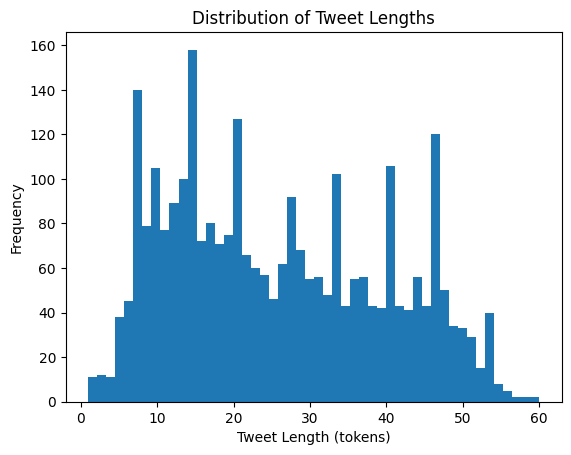

In [ ]:
# Testing on unbalanced dataset
lengths = [len(seq) for seq in train_sequences]
max_length = int(np.percentile(lengths, 95))
print("The length of the 95 of the sequences is", max_length)

plt.hist(lengths, bins=50)
plt.xlabel("Tweet Length (tokens)")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Lengths")
plt.show()

The padding can simply be done with the following code snippet. This code also, truncates the sequences larger than defined max length to have the same length.

In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

train_balanced_padded = pad_sequences(train_balanced_sequences, maxlen=max_length, padding='post')
val_balanced_padded = pad_sequences(val_balanced_sequences, maxlen=max_length, padding='post')
test_balanced_padded = pad_sequences(test_balanced_sequences, maxlen=max_length, padding='post')

print(train_padded[1:4]);print();print()
print(train_balanced_padded[4:7])

[[198405 197657  17787 269440  13925  44748 132143  62132 362478 274716
  373654 313368  92437 259421 400043 359724 245505 230410  76337 243923
   58939  65522 362533 237326  76337 187187 238514 193146 259125 283053
   45583 193012      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0]
 [ 43123 366222  47188 118536  44748 179253 291603 272955 365186 366222
  167808 344485 362533  46449 109002 179812 388448 366222 284253 243923
  394131 193146  44039  44962 227224  61407 277518 394825  44800 353615
  272955 198405 193146 311848      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0]
 [ 46362 275128  82705 133848  76111  46384  92085 191304 399945  63303
   47188  82705 399945 133848 393568  61939  55695  58939 390611 193146
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
    

Output proves that for sequences of tweets with less than max defined length, we are padding those sequences by zero to have same shape.

<a name='blstm-model-definition'></a>
## Step 4 - Model definition
In the following we will define the sexism classifier and model architecture. We will how two different modelings. One is a called based model which has one layer of Bi-LSTM with 64 units and the other model has an additional layer of Bi-LSTM with 32 units. However, since we kept both the balanced and unbalanced data, we will have the four following models:
- `Base model U` - Utalized for the unbalanced data
- `Model UA` - contains an additional layer compared to its successor
- `Base model B` - Utalized for the balanced data
- `Model BA` - contains an additional layer compared to its successor


In [ ]:
# Model U - Model for Unbalanced data ; has different embeddings
embedding_layer = Embedding(
    input_dim=vocab_count,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

# Model B - Model for Balanced data ; has different embeddings
embedding_balanced_layer = Embedding(
    input_dim=vocab_balanced_count,
    output_dim=embedding_dim,
    weights=[embedding_matrix_balanced],
    trainable=False
)

# Architecutures
def baseline_model(embedding_layer):
    baseline_model = Sequential()
    baseline_model.add(embedding_layer)  # Now the output shape is (batch_size, max_length, embedding_dim)
    baseline_model.add(Bidirectional(LSTM(64)))
    baseline_model.add(Dense(1, activation='sigmoid'))
    baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return baseline_model

def model_add_BLSTM(embedding_layer):
    model1 = Sequential()
    model1.add(embedding_layer)
    model1.add(Bidirectional(LSTM(64, return_sequences=True)))
    model1.add(Bidirectional(LSTM(32)))
    model1.add(Dense(1, activation='sigmoid'))
    model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model1

<a name='blstm-training'></a>
## Step 5 - Training
Next cell trains the compiled model and returns the evaluation.

In [ ]:
seeds = [41, 72, 97]
EPOCHS = 15
BATCH_SIZE = 64

# Dictionary to store F1 results for each seed
results = {
    'Model_Base_U': [],
    'Model_Base_UA': [],
    'Model_Base_B': [],
    'Model_Base_BA': []
}

# Dictionary to store model stuff
model_instances = {}
model_histories = {}


for seed in seeds:
    print(f"\n\n# -------- # -------- # Training with seed: {seed} # -------- # -------- #  ")
    print()

    tf.random.set_seed(seed)
    np.random.seed(seed)

    ### MODELS (RE)INITIALIZATION
    model_instances[f"Model_Base_U_seed_{seed}"] = baseline_model(embedding_layer)
    model_instances[f"Model_Base_UA_seed_{seed}"] = model_add_BLSTM(embedding_layer)

    model_instances[f"Model_Base_B_seed_{seed}"] = baseline_model(embedding_balanced_layer)
    model_instances[f"Model_Base_BA_seed_{seed}"] = model_add_BLSTM(embedding_balanced_layer)

    ### Unbalanced Section -----------------------------------------------------
    # --- Train Model_Base_U ---
    print("Training Model_Base_U")
    history_u = model_instances[f"Model_Base_U_seed_{seed}"].fit(
        train_padded, train_df['hard_label_task1'],
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(val_padded, val_df['hard_label_task1']),
        verbose=1
    );model_histories[f"Model_Base_U_seed_{seed}"] = history_u

    # --- Train Model_Base_UA ---
    print("Training Model_Base_UA")
    history_ua = model_instances[f"Model_Base_UA_seed_{seed}"].fit(
        train_padded, train_df['hard_label_task1'],
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(val_padded, val_df['hard_label_task1']),
        verbose=1
    );model_histories[f"Model_Base_UA_seed_{seed}"] = history_ua

    ### Balanced Section -------------------------------------------------------
    # --- Train Model_Base_B ---
    print("Training Model_Base_B")
    history_b = model_instances[f"Model_Base_B_seed_{seed}"].fit(
        train_balanced_padded, train_df_balanced['hard_label_task1'],
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(val_balanced_padded, val_df['hard_label_task1']),
        verbose=1
    );model_histories[f"Model_Base_B_seed_{seed}"] = history_b

    # --- Train Model_Base_BA ---
    print("Training Model_Base_BA")
    history_ba = model_instances[f"Model_Base_BA_seed_{seed}"].fit(
        train_balanced_padded, train_df_balanced['hard_label_task1'],
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(val_balanced_padded, val_df['hard_label_task1']),
        verbose=1
    );model_histories[f"Model_Base_BA_seed_{seed}"] = history_ba

    ### Evaluation Section -----------------------------------------------------
    # --- Evaluate Models on Validation Set ---
    print(f"Evaluating models for seed: {seed}")

    # Predictions and F1 scores
    predictions_u = (model_instances[f"Model_Base_U_seed_{seed}"].predict(val_padded) > 0.5).astype("int32")
    predictions_ua = (model_instances[f"Model_Base_UA_seed_{seed}"].predict(val_padded) > 0.5).astype("int32")
    predictions_b = (model_instances[f"Model_Base_B_seed_{seed}"].predict(val_balanced_padded) > 0.5).astype("int32")
    predictions_ba = (model_instances[f"Model_Base_BA_seed_{seed}"].predict(val_balanced_padded) > 0.5).astype("int32")

    # Calculate F1 scores
    f1_u = f1_score(val_df['hard_label_task1'], predictions_u, average='macro')
    f1_ua = f1_score(val_df['hard_label_task1'], predictions_ua, average='macro')
    f1_b = f1_score(val_df['hard_label_task1'], predictions_b, average='macro')
    f1_ba = f1_score(val_df['hard_label_task1'], predictions_ba, average='macro')

    # Store F1 Score results for later
    results['Model_Base_U'].append(f1_u)
    results['Model_Base_UA'].append(f1_ua)
    results['Model_Base_B'].append(f1_b)
    results['Model_Base_BA'].append(f1_ba)

    print(f"Seed {seed} - F1 Scores:")
    print(f"  Model_Base_U: {f1_u:.4f}")
    print(f"  Model_Base_UA: {f1_ua:.4f}")
    print(f"  Model_Base_B: {f1_b:.4f}")
    print(f"  Model_Base_BA: {f1_ba:.4f}")




# -------- # -------- # Training with seed: 41 # -------- # -------- #  

Training Model_Base_U
Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5673 - loss: 0.6741 - val_accuracy: 0.6519 - val_loss: 0.6614
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6871 - loss: 0.6014 - val_accuracy: 0.6835 - val_loss: 0.5871
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7347 - loss: 0.5426 - val_accuracy: 0.7278 - val_loss: 0.5640
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7649 - loss: 0.5102 - val_accuracy: 0.7342 - val_loss: 0.5489
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7821 - loss: 0.4840 - val_accuracy: 0.7405 - val_loss: 0.5341
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7982 - loss: 0.4622 - val_accuracy: 0.7595 - val_loss: 0.5051
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8038 - loss: 0.4405 - val_accuracy: 0.7722 - val_loss: 0.5113
Epoch 8/15
45/45 ━━

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Seed 41 - F1 Scores:
  Model_Base_U: 0.7582
  Model_Base_UA: 0.7649
  Model_Base_B: 0.7358
  Model_Base_BA: 0.7728


# -------- # -------- # Training with seed: 72 # -------- # -------- #  

Training Model_Base_U
Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6080 - loss: 0.6578 - val_accuracy: 0.7152 - val_loss: 0.6058
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7180 - loss: 0.5598 - val_accuracy: 0.7025 - val_loss: 0.5890
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7385 - loss: 0.5281 - val_accuracy: 0.7278 - val_loss: 0.5865
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7544 - loss: 0.5094 - val_accuracy: 0.7342 - val_loss: 0.5555
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7661 - loss: 0.4926 - val_accuracy: 0.7468 - val_loss: 0.5373
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7766 - loss: 0.4

Let's check out the outpus of training for the models:

In [ ]:
# --- Calculate Average F1 Scores Across Seeds for Validation set ---
average_f1_scores = {model: np.mean(scores) for model, scores in results.items()}
best_model = max(average_f1_scores, key=average_f1_scores.get)

print("\nAverage Macro-F1 scores across seeds on Validation set:")
for model_name, score in average_f1_scores.items():
    print(f"  {model_name}: {score:.4f}")

print(f"\nBest model based on average Macro-F1 score: {best_model}")


Average Macro-F1 scores across seeds on Validation set:
  Model_Base_U: 0.7647
  Model_Base_UA: 0.7603
  Model_Base_B: 0.7630
  Model_Base_BA: 0.7629

Best model based on average Macro-F1 score: Model_Base_U


The above results are the reported results about the validation accuracy.

Following cell goes through the hitories of models and plots the learning curve. This code snippet is taken from the [Geeks for Geeks](https://arc.net/l/quote/zaapqasw). However, before doing the visualization, we will calculate an average on the metrics of each model on each seeds. In other words, we average the different accuracies achieved by one model on different seeds. Then, we will use this average accuracy to demonstrate the learning curve. This demonstration is done in the error analysis section.

In [ ]:
average_acc_model_base = {
    'Model_Base_U':  {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': []},
    'Model_Base_UA': {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': []},
    'Model_Base_B':  {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': []},
    'Model_Base_BA': {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': []}
}

# Merging on model name
for model, history in model_histories.items():
    model_name = model.split("_seed_")[0]
    history_dict = history.history

    # Seperating validation and training accuracy
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    # Seperating validation and training loss
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    average_acc_model_base[model_name]['acc'].append(acc)
    average_acc_model_base[model_name]['val_acc'].append(val_acc)
    average_acc_model_base[model_name]['loss'].append(loss)
    average_acc_model_base[model_name]['val_loss'].append(val_loss)

# Averaging the metrics on seeds
for model_name, metric_dict in average_acc_model_base.items():
    for metric_name, metric_list in metric_dict.items():
        average_acc_model_base[model_name][metric_name] = np.mean(metric_list, axis=0)

<a name='blstm-test-evaluation'></a>
## Step 6 - Test Evaluation
Let's test the models on the test data:

In [ ]:
LSTM_test_predictions = {}

for i, (model_name, model) in enumerate(model_instances.items()):
    print(model_name, end=' : ')

    if (i + 1) % 4 in (3, 0):
        test_data = test_balanced_padded
    else:
        test_data = test_padded

    test_predictions = (model.predict(test_data) > 0.5).astype("int32")
    test_f1 = f1_score(test_df['hard_label_task1'], test_predictions, average='macro')

    LSTM_test_predictions[model_name] = [test_predictions, test_f1]


# Calculating the averages of the accuracies of models on test sets across the seeds:
average_LSTM_test_predictions = {
    'Model_Base_U': [],
    'Model_Base_UA': [],
    'Model_Base_B': [],
    'Model_Base_BA': []
}
for model_name in average_LSTM_test_predictions.keys():
    scores = []
    for seed in seeds:
        scores.append(LSTM_test_predictions[f"{model_name}_seed_{seed}"][1])
    average_LSTM_test_predictions[model_name] = np.mean(scores)

best_model_test = max(average_LSTM_test_predictions, key=average_LSTM_test_predictions.get)

print("\nAverage Macro-F1 scores across seeds on Test set:")
for model_name, score in average_LSTM_test_predictions.items():
    print(f"  {model_name}: {score:.4f}")

print(f"\nBest model based on average Macro-F1 score: {best_model_test}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Average Macro-F1 scores across seeds on Test set:
  Model_Base_U: 0.7172
  Model_Base_UA: 0.7173
  Model_Base_B: 0.6929
  Model_Base_BA: 0.6894

Best model based on average Macro-F1 score: Model_Base_UA


The above test results are reported in the report file as the test F1 score.

In the next cell, we are applying the majority voting to the predictions of the test set based on the seeds to also have a one prediction for it (same idea as averaging).

In [ ]:
LSTM_majority_voting_predictions = {}

def pred_voting(list_of_predictions):
    count = Counter([each_pred[0] for each_pred in list_of_predictions])
    if count[0] > count[1]:
        return 0
    elif count[1] > count[0]:
        return 1
    else:
        return 0

for model_name in set([name.split("_seed_")[0] for name in LSTM_test_predictions.keys()]):
    predictions = []
    for seed in seeds:
        predictions.append(LSTM_test_predictions[f"{model_name}_seed_{seed}"][0])

    # majority voting on that specific predictions
    majority_vote = []
    list_of_pred_for_that_idx = []
    for voting_for_index in range(len(predictions[0])):
        list_of_pred_for_that_idx = [pred_of_each_seed[voting_for_index] for pred_of_each_seed in predictions]
        majority_vote.append(pred_voting(list_of_pred_for_that_idx))

    LSTM_majority_voting_predictions[model_name] = majority_vote


<a name='transformer-model'></a>
# Transformer Model

In this section, we will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




<a name='transformer-preprocessing'></a>
## Step 1 - Importing the Transformer and Preprocessing

In [ ]:
train_data = DS.from_pandas(train_df)
train_data_balanced = DS.from_pandas(train_df_balanced)

val_data = DS.from_pandas(val_df)
test_data = DS.from_pandas(test_df)

We need to tokenize the text with transformer's tokenization!

In [ ]:
%%capture
# Load the Tokenizer
task='hate'
MODEL_NAME = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_text(texts):
    return tokenizer(texts['tweet'], truncation=True, max_length=max_length) # Same Max length as the BLSTMs

train_data = train_data.map(preprocess_text, batched=True)
train_data_balanced = train_data_balanced.map(preprocess_text, batched=True)
val_data = val_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)

In [ ]:
train_data = train_data.rename_column('hard_label_task1', 'label')
train_data_balanced = train_data_balanced.rename_column('hard_label_task1', 'label')
val_data = val_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')

<a name='transformer-modeling'></a>
## Step 2 - Defining the Model and Metrics
It receives a batch of (input_ids, attention_mask, token_type_ids, label)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                           num_labels=2,
                                                           id2label={0: 'NO', 1: 'YES'},
                                                           label2id={'NO': 0, 'YES': 1})

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In the following, we will use the Trainer API to do the training.

In [ ]:
acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    acc = acc_metric.compute(predictions=predictions, references=labels)
    return {**f1, **acc}

<a name='transformer-training'></a>
## Step 3 - Training
Training the initialized models with different seeds. We are also saving the models for laters when we are calling them on the test sets.

> NLP Tutorials Notebooks was fruitful for these sections.

In [ ]:
EPOCHS = 5
seeds = [512, 1024, 2048]
transformer_results_path = "Transformer_results"

# Directory to save results
results_dir = Path(transformer_results_path)
results_dir.mkdir(exist_ok=True)

# Results of each seed and dataset
log_history = []

datasets = {
    "unbalanced": train_data,
    "balanced": train_data_balanced
}

for seed in seeds:
    set_seed(seed)
    print(f"Training with seed: {seed}")

    for dataset_name, dataset in datasets.items():
        print(f"Training on {dataset_name} dataset")

        # --------------------- Arguments settings
        output_dir = results_dir / f"{dataset_name}_seed_{seed}"
        output_dir.mkdir(exist_ok=True)

        training_args = TrainingArguments(
            output_dir=str(output_dir),
            learning_rate=2e-5,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=EPOCHS,
            weight_decay=0.01,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_accuracy",
            seed=seed,                                    # Upadating Every Seed
            report_to='none'
        )

        # (Re)Initialize Trainer On the new seed and data
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=dataset,                            # Updating dataset
            eval_dataset=val_data,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )
        train_output = trainer.train()

        # Save the model and tokenizer for test section
        trainer.model.save_pretrained(str(output_dir / "model"))
        tokenizer.save_pretrained(str(output_dir / "tokenizer"))

        # Evaluate the model
        eval_results = trainer.evaluate()
        print(f"Dataset: {dataset_name} -> Results for seed {seed}: {eval_results}")

        # Save log history
        log_hist = trainer.state.log_history
        for log in log_hist:
            if 'epoch' in log:
                log_history.append({
                    'seed': seed,
                    'dataset': dataset_name,
                    'epoch': log['epoch'],
                    'log': log
                })


Training with seed: 512
Training on unbalanced dataset


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.321835,0.868003,0.873418
2,0.405900,0.509828,0.852211,0.860759
3,0.268000,0.690080,0.843176,0.848101
4,0.268000,0.815408,0.840726,0.848101
5,0.123000,0.894540,0.840726,0.848101


Dataset: unbalanced -> Results for seed 512: {'eval_loss': 0.32183462381362915, 'eval_f1': 0.8680033416875522, 'eval_accuracy': 0.8734177215189873, 'eval_runtime': 0.2548, 'eval_samples_per_second': 619.977, 'eval_steps_per_second': 78.478, 'epoch': 5.0}
Training on balanced dataset


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.435585,0.844986,0.854430
2,0.288000,0.497024,0.882905,0.886076
3,0.288000,0.885874,0.861767,0.867089
4,0.106200,0.971819,0.838927,0.841772
5,0.106200,0.978723,0.850052,0.854430


Dataset: balanced -> Results for seed 512: {'eval_loss': 0.49702438712120056, 'eval_f1': 0.8829051383399209, 'eval_accuracy': 0.8860759493670886, 'eval_runtime': 0.2578, 'eval_samples_per_second': 612.851, 'eval_steps_per_second': 77.576, 'epoch': 5.0}
Training with seed: 1024
Training on unbalanced dataset


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,1.068756,0.830348,0.841772
2,0.192000,1.031616,0.827453,0.835443
3,0.064500,1.320768,0.831506,0.841772
4,0.064500,1.148819,0.848602,0.854430
5,0.013800,1.244483,0.853135,0.860759


Dataset: unbalanced -> Results for seed 1024: {'eval_loss': 1.2444831132888794, 'eval_f1': 0.8531350346459354, 'eval_accuracy': 0.8607594936708861, 'eval_runtime': 0.2479, 'eval_samples_per_second': 637.308, 'eval_steps_per_second': 80.672, 'epoch': 5.0}
Training on balanced dataset


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,1.312139,0.861026,0.867089
2,0.057000,1.322465,0.854804,0.860759
3,0.057000,1.505570,0.840726,0.848101
4,0.013500,1.626680,0.845984,0.854430
5,0.013500,1.632241,0.845984,0.854430


Dataset: balanced -> Results for seed 1024: {'eval_loss': 1.3121387958526611, 'eval_f1': 0.8610261780104712, 'eval_accuracy': 0.8670886075949367, 'eval_runtime': 0.2621, 'eval_samples_per_second': 602.734, 'eval_steps_per_second': 76.295, 'epoch': 5.0}
Training with seed: 2048
Training on unbalanced dataset


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.763336,0.854804,0.860759
2,0.044000,1.192183,0.838776,0.848101
3,0.028100,0.968528,0.862455,0.867089
4,0.028100,1.181212,0.866486,0.873418
5,0.017500,1.210813,0.866486,0.873418


Dataset: unbalanced -> Results for seed 2048: {'eval_loss': 1.181212067604065, 'eval_f1': 0.8664863951326687, 'eval_accuracy': 0.8734177215189873, 'eval_runtime': 0.2502, 'eval_samples_per_second': 631.531, 'eval_steps_per_second': 79.941, 'epoch': 5.0}
Training on balanced dataset


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,1.527544,0.829289,0.835443
2,0.053400,1.451357,0.828404,0.835443
3,0.053400,1.618985,0.829289,0.835443
4,0.017700,1.619357,0.814180,0.822785
5,0.017700,1.618042,0.822272,0.829114


Dataset: balanced -> Results for seed 2048: {'eval_loss': 1.5275442600250244, 'eval_f1': 0.8292885638297872, 'eval_accuracy': 0.8354430379746836, 'eval_runtime': 0.2526, 'eval_samples_per_second': 625.6, 'eval_steps_per_second': 79.19, 'epoch': 5.0}


<a name='transformer-test-evaluation'></a>
## Step 4 - Test Evaluation
Here, models and tokenizers are being retreived from the saved directory and then evaluation on test set is being applied.

In [ ]:
def compute_metrics_test(output_info):
    predictions, labels = output_info

    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    acc = acc_metric.compute(predictions=predictions, references=labels)
    return {**f1, **acc}

# Path to saved models
results_dir = Path(transformer_results_path)

# Evaluation results
test_results = []

# os.environ["WANDB_DISABLED"] = "true"
eval_args = TrainingArguments(
    output_dir="temp_eval_output",
    report_to="none"
)

for seed in seeds:
    for dataset_name in datasets.keys():
        # Retrieving Model and Tokenizer
        model_dir = results_dir / f"{dataset_name}_seed_{seed}" / "model"
        tokenizer_dir = results_dir / f"{dataset_name}_seed_{seed}" / "tokenizer"

        model = AutoModelForSequenceClassification.from_pretrained(model_dir)
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir)

        # Initialize a new Trainer for inference
        trainer = Trainer(
            model=model,
            tokenizer=tokenizer, # This is also deprecating
            args=eval_args
        )

        # Predict on test data
        predictions = trainer.predict(test_data)

        # Extract metrics and predictions
        metrics = predictions.metrics
        pred_labels = predictions.predictions.argmax(axis=-1)
        true_labels = test_data["label"]  # True labels from test data

        # Save results for this seed
        test_results.append({
            "seed": seed,
            "dataset": dataset_name,
            "metrics": metrics,
            "predictions": pred_labels.tolist(),
            "true_labels": true_labels
        })

# Print all test evaluation results
res_avg = {
    "unbalanced": [[], []],
    "balanced": [[], []]
}
for result in test_results:
    output = (np.array(result['predictions']), np.array(result['true_labels']))
    test_met = compute_metrics_test(output)
    res_avg[result['dataset']][0].append(test_met['f1'])
    res_avg[result['dataset']][1].append(test_met['accuracy'])
    print(f" Seed: {result['seed']}, Dataset: {result['dataset']}, Test Metrics: {test_met}")

 Seed: 512, Dataset: unbalanced, Test Metrics: {'f1': 0.823482940798894, 'accuracy': 0.8251748251748252}
 Seed: 512, Dataset: balanced, Test Metrics: {'f1': 0.8386558744174638, 'accuracy': 0.8391608391608392}
 Seed: 1024, Dataset: unbalanced, Test Metrics: {'f1': 0.8373714398734178, 'accuracy': 0.8391608391608392}
 Seed: 1024, Dataset: balanced, Test Metrics: {'f1': 0.8268914829226113, 'accuracy': 0.8286713286713286}
 Seed: 2048, Dataset: unbalanced, Test Metrics: {'f1': 0.8376043055349824, 'accuracy': 0.8391608391608392}
 Seed: 2048, Dataset: balanced, Test Metrics: {'f1': 0.8281987471037502, 'accuracy': 0.8286713286713286}


In [ ]:
for datasets, metrics in res_avg.items():
    print("Dataset: ", datasets)
    print(f"Average F1 Score for {datasets}: {np.mean(metrics[0])}")
    print(f"Average Accuracy for {datasets}: {np.mean(metrics[1])}\n")

Dataset:  unbalanced
Average F1 Score for unbalanced: 0.832819562069098
Average Accuracy for unbalanced: 0.8344988344988344

Dataset:  balanced
Average F1 Score for balanced: 0.8312487014812749
Average Accuracy for balanced: 0.8321678321678322



The above results are reported in the transformer table in the report file.

An amazing performance is being performed by the transformer. Transformer is getting the accuracy of **~0.83** on the test set

As we have 3 seeds for rubostness, in the next cell, we have applied a majority voting for the predictions on each tweets and as the results we came up with two arrays of predictions one for the balance dataset and another for the unbalance dataset.  

In [ ]:
predictions_in_each_seed = {
    "unbalanced": [],
    "balanced": []
}
for each_test_result in test_results:
    predictions_in_each_seed[each_test_result['dataset']].append(each_test_result['predictions'])

def pred_voting_for_transformer(list_of_predictions):
    count = Counter(list_of_predictions)
    if count[0] > count[1]:
        return 0
    elif count[1] > count[0]:
        return 1
    else:
        return 0

average_predictions_in_each_seed = {
    "unbalanced": [],
    "balanced": []
}
for each_dataset in predictions_in_each_seed.keys():
    transformer_majority_vote = []
    transformer_list_of_pred_for_that_idx = []
    for voting_for_index in range(len(predictions_in_each_seed["unbalanced"][0])):
        transformer_list_of_pred_for_that_idx = [pred_of_each_seed[voting_for_index] for pred_of_each_seed in predictions_in_each_seed[each_dataset]]
        transformer_majority_vote.append(pred_voting_for_transformer(transformer_list_of_pred_for_that_idx))
    average_predictions_in_each_seed[each_dataset] = transformer_majority_vote

<a name='result-analysis'></a>
# Results Analysis


<a name='curve-analysis'></a>
## BLSTM Curve Analysis
Following cell visualizes the accuracy curve of both training and validation of the BLSTM.

In [ ]:
for model_name, metrics in average_acc_model_base.items():
    print(" ".join(model_name.split('_')), "------ # ------------- # \n\n")
    print("Training Accuracy: ", metrics['acc'])
    print("Validation: ", metrics['val_acc'])



# ------------- # ------ Model Base U ------ # ------------- # 




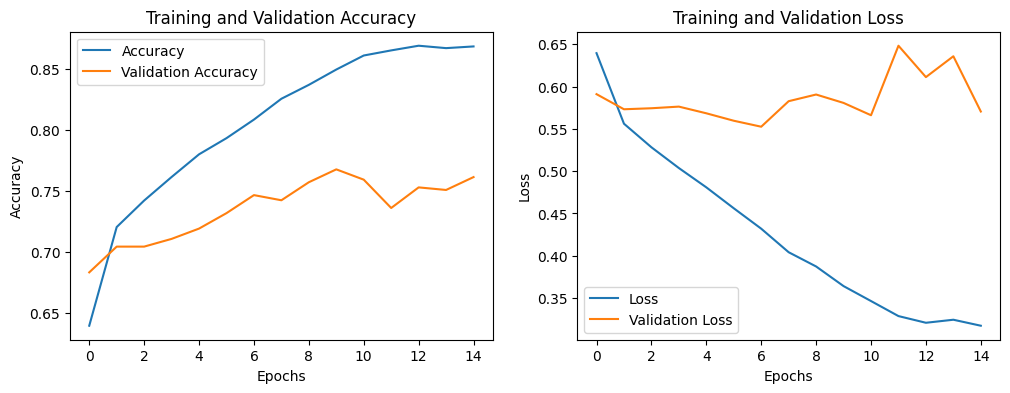



# ------------- # ------ Model Base UA ------ # ------------- # 




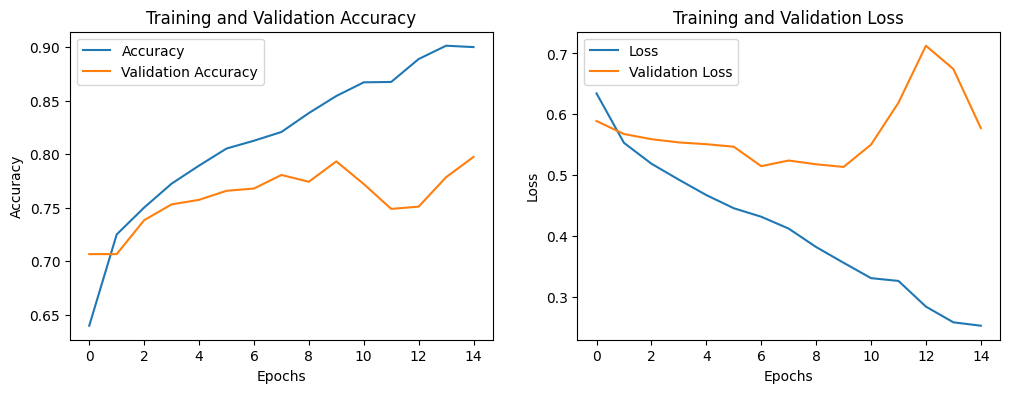



# ------------- # ------ Model Base B ------ # ------------- # 




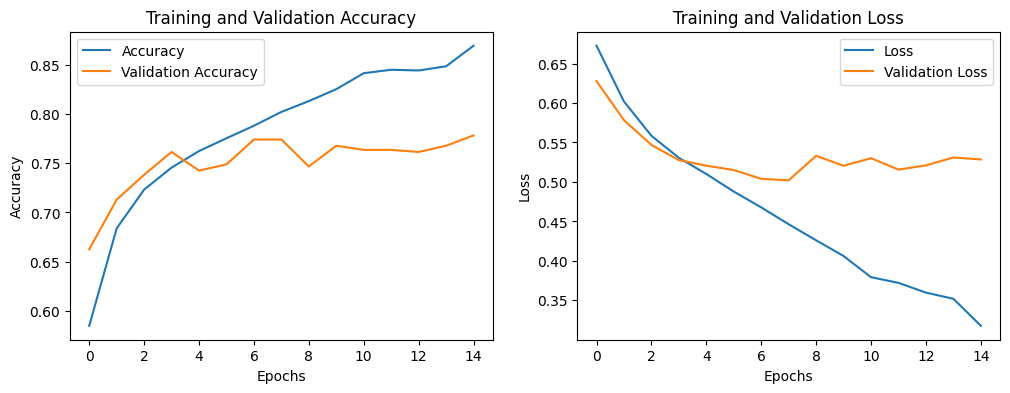



# ------------- # ------ Model Base BA ------ # ------------- # 




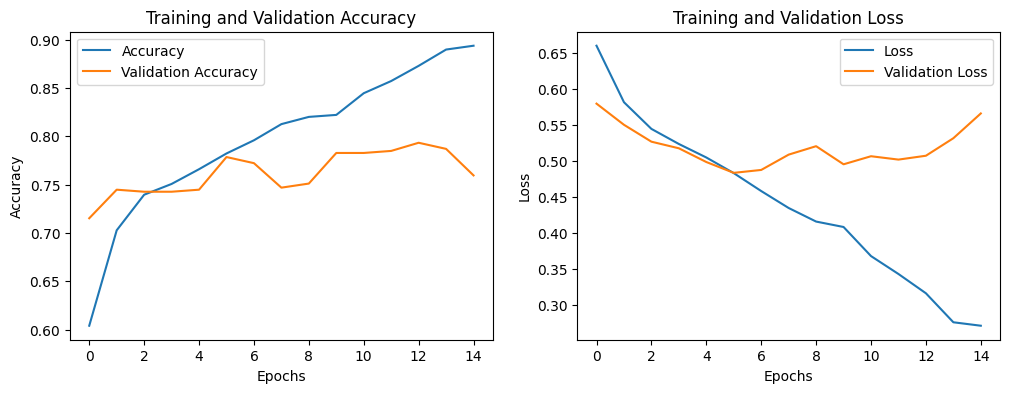

In [ ]:
for model_name, metrics in average_acc_model_base.items():
    print("\n\n# ------------- # ------", " ".join(model_name.split('_')), "------ # ------------- # \n\n")
    # Seperating validation and training accuracy
    acc = metrics['acc']
    val_acc = metrics['val_acc']

    # Seperating validation and training loss
    loss = metrics['loss']
    val_loss = metrics['val_loss']

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Accuracy', 'Validation Accuracy'])

    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Loss', 'Validation Loss'])

    plt.show()

The losses of both the training and validation data on all of the models have almost a same structure. Training loss for all the four different models is decreasing epoch after epoch. However, the validation loss, almost in all the four models, starts increasing after epoch ~5.

- This suggests the models are overfitting to the training data and are losing the generalization abilities.

The same is also true for the accuracy section. While the accuracy on the training is getting better and better after each epoch, the accuracy of validation data is not experiencing a better results and even in some cases it gets worse after epoch ~8.

<a name='tokenization-analysis'></a>
## Vocabulary and Tokenization
Following cell shows the total number of tokens that are unknown to the model.

In [ ]:
print("OOV in unbalanced training set:", check_OOV(train_sequences, index_to_word))
print("OOV in unbalanced validation set:", check_OOV(val_sequences, index_to_word))
print("OOV in unbalanced test set:", check_OOV(test_sequences, index_to_word))
print('----------')
print("OOV in balanced training set:", check_OOV(train_balanced_sequences, index_to_word))
print("OOV in balanced validation set:", check_OOV(val_balanced_sequences, index_to_word))
print("OOV in balanced test set:", check_OOV(test_balanced_sequences, index_to_word))

OOV in unbalanced training set: 0
OOV in unbalanced validation set: 295
OOV in unbalanced test set: 456
----------
OOV in balanced training set: 0
OOV in balanced validation set: 315
OOV in balanced test set: 473


Why there is a difference between the number of OOV of balanced and unbalanced data? This is because, unbalanced data is the whole dataset, a larger dataset, which means there are more tokens inside it. As the results, the model has a larger vocabulary list. However, in the balanced dataset we have narrowed down the larger class, meaning that there were tweets that we didn't see them and we haven't add them to the vocabulary. Leading to a smaller vocabulary list.

In this project we have tokenized the data based on the word (Word Tokenization technique) where we choose all the preprocessed, lemmatized word types as a token. However, in modern Language Models, tokenization are being cared more carefully.
- Changing the strategy for the tokenization also helps in encoutering less OOV which helps the model to understand the data better. Having said that, we can say that one of the reason that transformer is doing better in this task, here in this project, is the different tokenization it uses.

<a name='confusion-matrix-analysis'></a>
## Confusion Matrix
Next, we'll define the metric functions and demonstrate the confusion matrix.

In [ ]:
acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(responses, y_true):
    """
    This function takes predicted and ground-truth labels and compute metrics.
    In particular, this function compute accuracy and fail-ratio metrics.
    This function internally invokes `process_response` to compute metrics.

    Inputs:
        responses: generated LLM responses
        y_true: ground-truth binary labels

    Outputs:
        dictionary containing desired metrics
    """
    f1 = f1_metric.compute(predictions=responses, references=y_true, average='macro')
    acc = acc_metric.compute(predictions=responses, references=y_true)
    return {**f1, **acc}

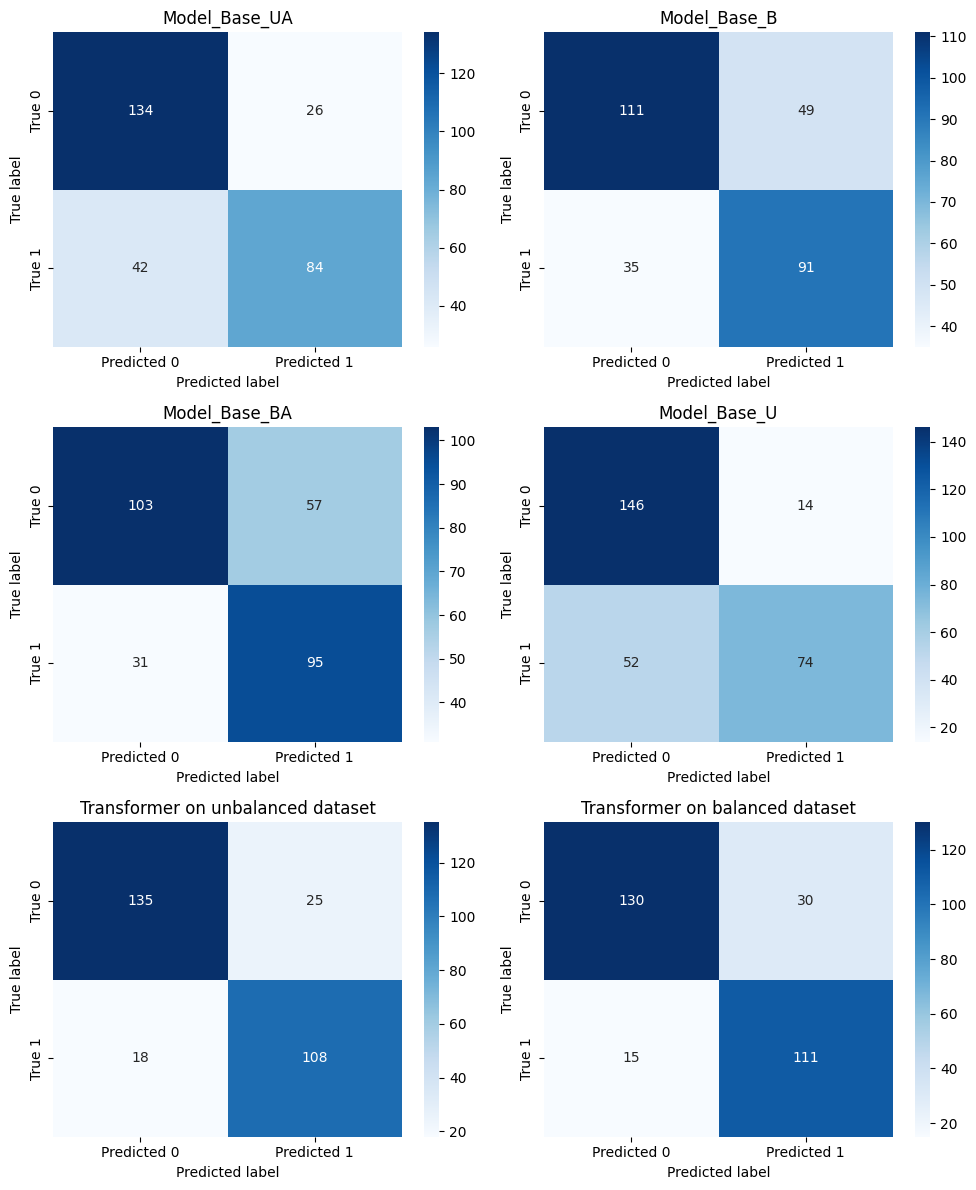

In [ ]:
ground_truth = np.array(test_df['hard_label_task1'])
preds_list = {}

for lstm_model_name in LSTM_majority_voting_predictions.keys():
    prediction = LSTM_majority_voting_predictions[lstm_model_name]
    preds_list[lstm_model_name] = prediction

for dataset_name in average_predictions_in_each_seed.keys():
    preds_list[f"Transformer on {dataset_name} dataset"] = average_predictions_in_each_seed[dataset_name]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 3 * 4))
axes = axes.ravel()

for idx, model_name in enumerate(preds_list.keys()):
    predictions = preds_list[model_name]

    cm = confusion_matrix(ground_truth, predictions)

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["True 0", "True 1"],
                ax=axes[idx])

    axes[idx].set_title(f"{model_name}")
    axes[idx].set_ylabel("True label")
    axes[idx].set_xlabel("Predicted label")

plt.tight_layout()
plt.show()

By studying these diagrams we can get a good understanding on the difference of the datasets that we have worked on.

#### BLSTM Diagram Analysis
Here's the corresponding meaning of each name of the diagrams:
- Model Base U  : The Base BLSTM; trained on `unbalance` data
- Model Base UA : The BLSTM with Additional LSTM layer; trained on `unbalance` data
- Model Base B  : The Base BLSTM; trained on `balance` data
- Model Base BA : The BLSTM with Additional LSTM layer; trained on `balance` data

Diagrams for the unbalanced datasets are showing that the models is performing significantly better on predicting the tweets with the class 0, none sexist tweets. As expected, this is due the more data that we have for the class 0. Additionaly, between these two models trained on this dataset, the model with additional LSTM layer is performing poorer than the base model. This is due to the overfitting that happens with more layers. Because the amount of data for such architecture is very less.

However, unexpectedly, the model trained on the balanced data are also performing better on classifying the non-sexist tweets. This may be due to the randomness, since during development, we've seen so many changes in these numbers. However, this attitude of cannot strongly be assigned to the randomness. One other reason that may causes this better performing on the class 0 may be because of the validation set. We also had the unbalanced data on the validation set. Although the model is not learning directly from the validation set, validation set is the set that helps model to update its weights and a bias in the validation set indeed can infect the training.

#### Transformer Diagram Analysis
At the third row we have the confusion matrix of the transformer. Which is a showing that transformers are indeed more powerful than the BLSTM.

The difference between the transformer trained on the balanced data (the one on the right) and the transformer trained on the unbalanced data (the diagram on the left) with the results of the BLSTM architecuters can prove that, no matter how strong the architecture is, as long as the quality of the data is not good, or we don't have enough data for training, the model cannot perform better after some points.

Here, confusion matrices are showing us that transformer makes mistakes less than the BLSTM, but it is not performing significantly better. As mentioned, this may have different reasons, and one of them is the amount of data and the quality of data. The other one is the amount of training. A model overfitted to the training data cannot perform well on unseen data.

<a name='other-analysis'></a>
## Other Notes
Other notes:

- One of the things that can improve the performance is to augmente the data. Data augmentation can be used to increase the amount of data so our model doesn't overfit the data easily.
- Data Balancing is an important step that should be considered as well. Although we have experienced in some cases that the accuracy of the models on the unbalanced dataset was better, however, we must not rely on it. Because having an unbalanced data leads to a bias model, which maybe good even when you test it on test set, but cannot rely on it since the model is able to predict one class better than the other. Hence, we cannot say that the performance of the model is good because of the good predictino it has on that class. But on the other side, it is performing poor.
- One other things that could be exploit from is to use the grid search strategy to find the better parameters for the model. Although, still, when we don't have enough data, we cannot change the performance significantly better.
- One other things that can be done is to to instead of down sampling the majority class to balance the data, we could upsample the minority class the to have the same amount of examples as the mjority class. This increases the amount of data a bit.
    - This upsampling is also can be complex as the characteristic of text is complex. However, finding the similarities between words and even sentences, could help us increase the number of examples we have for the minority class.
